In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler

np.random.seed(0)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 80)

In [4]:
# load data set
df = pd.read_csv('../data/train.csv')
df_train = df.copy()

df_train.iloc[0]

listing_id                                                                                     122881
title                                                       hdb flat for sale in 866 yishun street 81
address                                                                      sembawang / yishun (d27)
property_name                                                                    866 yishun street 81
property_type                                                                             hdb 4 rooms
tenure                                                                                            NaN
built_year                                                                                     1988.0
num_beds                                                                                          3.0
num_baths                                                                                         2.0
size_sqft                                                                         

In [5]:
def drop_cols_for_regression(df):
    drop_columns = [
        'listing_id',
        'address',
        'title',
        'property_name',
        'total_num_units',
        'available_unit_types',
        'property_details_url',
        'elevation',
        'tenure',
        'property_type',
        'floor_level',
        'furnishing',
        'built_year',
    ]
    return df.drop(columns=drop_columns)

def prepare_data_for_regression(df):
    adfs = read_aux_csv('../data')
    df = join_aux(df, adfs)
    df = drop_cols_for_regression(df)

    return df

In [6]:
df_train = preprocess(df_train)
df_train = prepare_data_for_regression(df_train)
df_train.head()

,num_beds,num_baths,size_sqft,lat,lng,subzone,planning_area,price,property_type_private,property_type_public,tenure_high_year,tenure_low_year,floor_level_ground,floor_level_high,floor_level_low,floor_level_mid,floor_level_penthouse,floor_level_top,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,nearest_mrt_distance_in_km,line_cc,line_ce,line_cg,line_dt,line_ew,line_ne,line_ns,line_te,nearest_pri_sch_distance_in_km,nearest_gep_pri_sch_distance_in_km,gep_pri_sch_within_1km,gep_pri_sch_within_1km_2km,gep_pri_sch_outside_2km,pri_sch_within_500m,pri_sch_outside_500m,nearest_com_centre_distance_in_km,cc_type_BN,cc_type_CR,cc_type_IEBP,cc_type_IEPB,cc_type_IHL,nearest_mall_distance_in_km,area_size,population,density,region
0,3.0,2.0,1115,1.414399,103.837196,yishun south,yishun,514500.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.574204,0,0,0,0,0,0,1,0,0.275582,6.194099,0,0,1,1,0,3.338999,0,1,0,0,0,0.621334,1.3402,42240,31517.683928,n
1,4.0,2.0,1575,1.372597,103.875625,serangoon north,serangoon,995400.0,0,1,0,1,0,0,0,0,0,0,0,0,1,1.734303,0,0,0,0,0,1,0,0,0.122925,0.122925,1,0,0,1,0,2.401882,1,0,0,0,0,0.552544,0.6847,15940,23280.268731,ne
2,4.0,6.0,3070,1.298773,103.895798,mountbatten,marine parade,8485000.0,1,0,1,0,0,0,1,0,0,0,1,0,0,1.319766,1,0,0,0,0,0,0,0,0.891475,1.872702,0,1,0,0,1,2.171328,1,0,0,0,0,0.824208,1.7119,9980,5829.779777,c
3,3.0,2.0,958,1.312364,103.803271,farrer court,bukit timah,2626000.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.726006,1,0,0,0,0,0,0,0,1.090371,1.090371,0,1,0,0,1,1.605928,1,0,0,0,0,0.907063,0.5588,6180,11059.413028,c
4,2.0,1.0,732,1.273959,103.843635,anson,downtown core,1764000.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.371115,0,0,0,0,1,0,0,0,0.464835,2.742534,0,0,1,1,0,1.869574,0,1,0,0,0,0.430415,0.1032,80,775.193798,c


In [7]:
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

In [10]:
def data_pipeline(model=None, polynomial=2):
    preprocessor = make_column_transformer(
                    (StandardScaler(), ['num_beds', 'num_baths', 'size_sqft']),
                    (OneHotEncoder(handle_unknown='ignore'), ["region", "subzone", "planning_area"]),
                    remainder='passthrough')
    
    pipeline = [preprocessor]
    
    if polynomial > 0:
        pipeline.append(PolynomialFeatures(polynomial))
    
    if model != None:
        pipeline.append(model)
        
    return make_pipeline(*pipeline)

def pipelined_model(model):
    return TransformedTargetRegressor(regressor=data_pipeline(model), transformer=StandardScaler())

def transform_data(df):
    """
        Obtain the data after going through all the pipeline, before being fed into the model
        Would be useful for debugging purposes
    """
    p = data_pipeline(polynomial=0)
    p.fit(df)
    
    return pd.DataFrame(data=p.transform(df).toarray(), columns=p.get_feature_names_out())

In [13]:
transformed_X = transform_data(X_train)
transformed_X.head()

,standardscaler__num_beds,standardscaler__num_baths,standardscaler__size_sqft,onehotencoder__region_c,onehotencoder__region_e,onehotencoder__region_n,onehotencoder__region_ne,onehotencoder__region_w,onehotencoder__subzone_admiralty,onehotencoder__subzone_alexandra hill,onehotencoder__subzone_alexandra north,onehotencoder__subzone_aljunied,onehotencoder__subzone_anak bukit,onehotencoder__subzone_anchorvale,onehotencoder__subzone_ang mo kio town centre,onehotencoder__subzone_anson,onehotencoder__subzone_balestier,onehotencoder__subzone_bangkit,onehotencoder__subzone_bayshore,onehotencoder__subzone_bedok north,onehotencoder__subzone_bedok reservoir,onehotencoder__subzone_bedok south,onehotencoder__subzone_bencoolen,onehotencoder__subzone_bendemeer,onehotencoder__subzone_bidadari,...,remainder__line_cc,remainder__line_ce,remainder__line_cg,remainder__line_dt,remainder__line_ew,remainder__line_ne,remainder__line_ns,remainder__line_te,remainder__nearest_pri_sch_distance_in_km,remainder__nearest_gep_pri_sch_distance_in_km,remainder__gep_pri_sch_within_1km,remainder__gep_pri_sch_within_1km_2km,remainder__gep_pri_sch_outside_2km,remainder__pri_sch_within_500m,remainder__pri_sch_outside_500m,remainder__nearest_com_centre_distance_in_km,remainder__cc_type_BN,remainder__cc_type_CR,remainder__cc_type_IEBP,remainder__cc_type_IEPB,remainder__cc_type_IHL,remainder__nearest_mall_distance_in_km,remainder__area_size,remainder__population,remainder__density
0,-0.078622,-0.428734,-0.316096,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.275582,6.194099,0.0,0.0,1.0,1.0,0.0,3.338999,0.0,1.0,0.0,0.0,0.0,0.621334,1.3402,42240.0,31517.683928
1,0.716608,-0.428734,-0.047141,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.122925,0.122925,1.0,0.0,0.0,1.0,0.0,2.401882,1.0,0.0,0.0,0.0,0.0,0.552544,0.6847,15940.0,23280.268731
2,0.716608,2.359516,0.826962,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.891475,1.872702,0.0,1.0,0.0,0.0,1.0,2.171328,1.0,0.0,0.0,0.0,0.0,0.824208,1.7119,9980.0,5829.779777
3,-0.078622,-0.428734,-0.407892,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.090371,1.090371,0.0,1.0,0.0,0.0,1.0,1.605928,1.0,0.0,0.0,0.0,0.0,0.907063,0.5588,6180.0,11059.413028
4,-0.873852,-1.125796,-0.540031,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.464835,2.742534,0.0,0.0,1.0,1.0,0.0,1.869574,0.0,1.0,0.0,0.0,0.0,0.430415,0.1032,80.0,775.193798


In [12]:
# https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(transformed_X, y_train)

In [22]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = transformed_X.columns
mutual_info.sort_values(ascending=False)[0:100]

standardscaler__size_sqft                        2.243578
remainder__lat                                   2.006736
remainder__property_type_private                 1.975442
remainder__nearest_gep_pri_sch_distance_in_km    1.974533
remainder__lng                                   1.958992
                                                   ...   
onehotencoder__subzone_sunset way                0.024871
onehotencoder__subzone_woodlands east            0.024290
onehotencoder__subzone_toh tuck                  0.023947
onehotencoder__subzone_dhoby ghaut               0.022422
remainder__floor_level_high                      0.021960
Length: 100, dtype: float64

<AxesSubplot:>

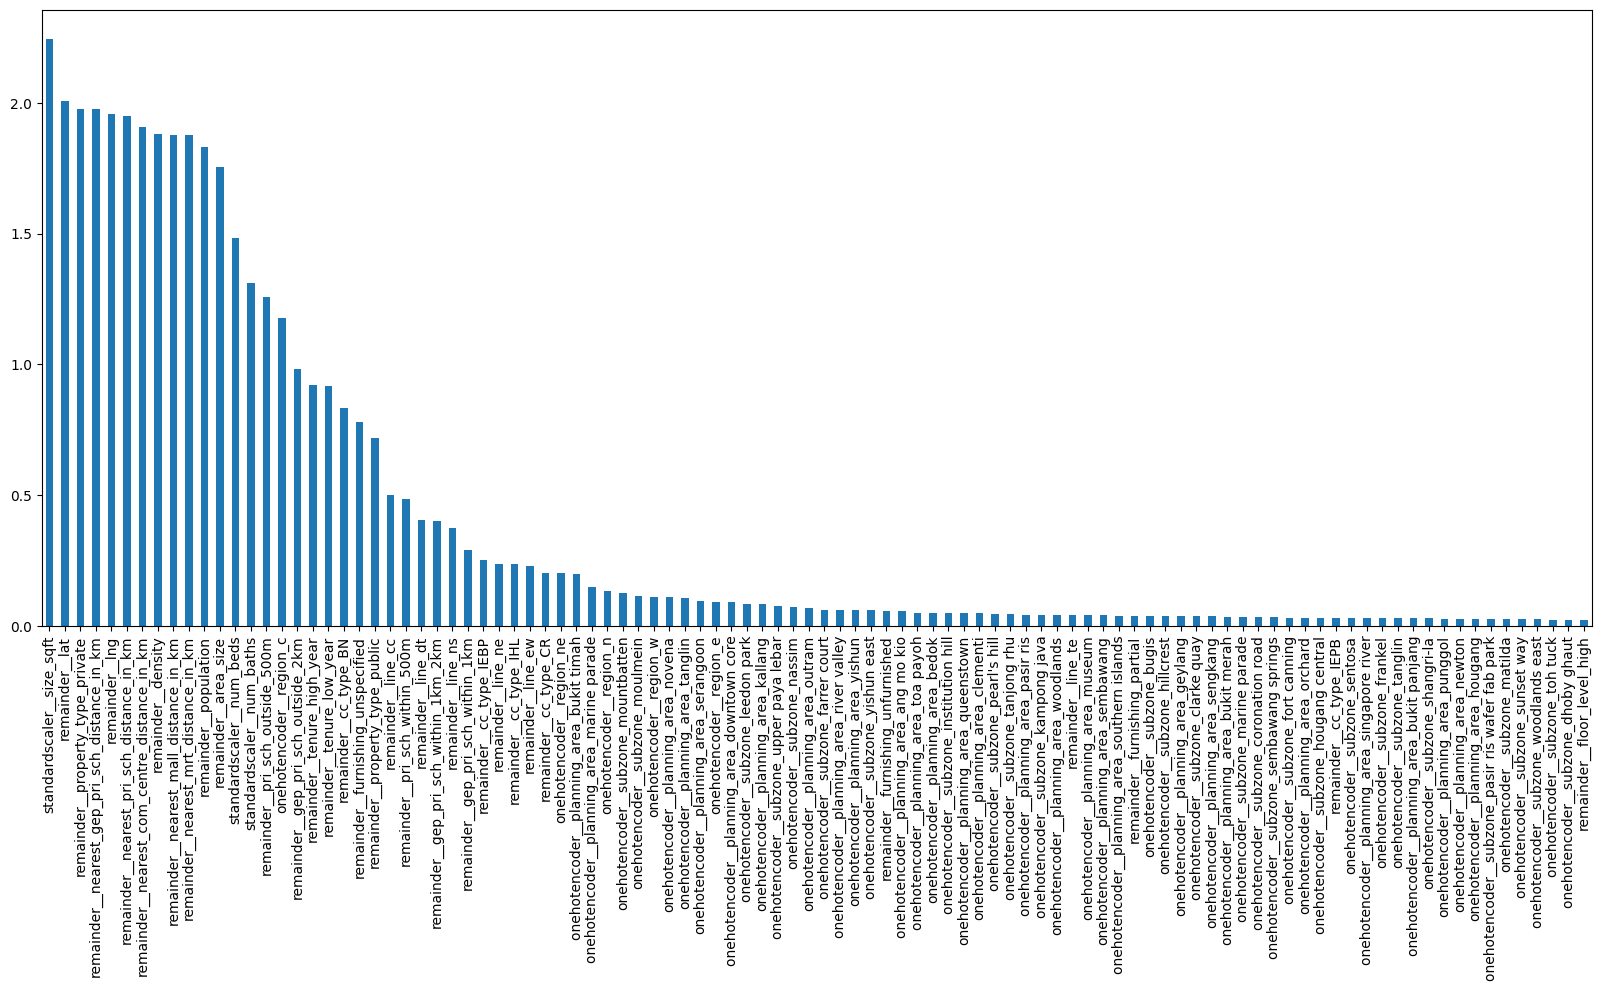

In [20]:
mutual_info.sort_values(ascending=False)[0:100].plot.bar(figsize=(20, 8))